### Introduction

#### The objective of the notebook is to determine the future depth to groundwater of a well belonging to the aquifier in Petrigrano over the next quarter

#### The determining factors consists of:
- Rainfall: the quantity of rain falling, expressed in millimeters (mm), in the area X
- Depth to Groundwater (Target Feature): the groundwater level, expressed in ground level (meters from the ground floor), detected by the piezometer Y
- Temperature: the temperature, expressed in °C, detected by the thermometric station Z
- Drainge Volume: the volume of water, expressed in cubic meters (mc), taken from the drinking water treatment plant K
- River Hydrometry: the groundwater level, expressed in meters (m), detected by the hydrometric station H


In [51]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 200) #total row able to be displayed in jupyter notebook
sns.set_style("whitegrid")

#### || Only requried columns will be selected (List above) and renamed to make the columns more readable

In [52]:
df = pd.read_csv("Aquifer_Petrignano.csv")

# Drop data before 2009 for the purpose of this tutorial
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Drop one of the target columns, so we can focus on only one target
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

# Simplify column names
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


#### ||The date column will have to be converted to datetime format for later data processing

In [53]:
from datetime import datetime, date 

df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
df.head().style.set_properties(subset=['Date'], **{'background-color': 'dodgerblue'})

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


#### || Checking if all timestamps are equidistant

In [54]:
df['Time_Interval'] = df.Date - df.Date.shift(1)
print(f"{df['Time_Interval'].value_counts()}")
df = df.drop('Time_Interval', axis=1)

1 days    4198
Name: Time_Interval, dtype: int64



#### || To begin with, a lineplot sorted chronogically is created for all captured columns to obtain a quick visual representation

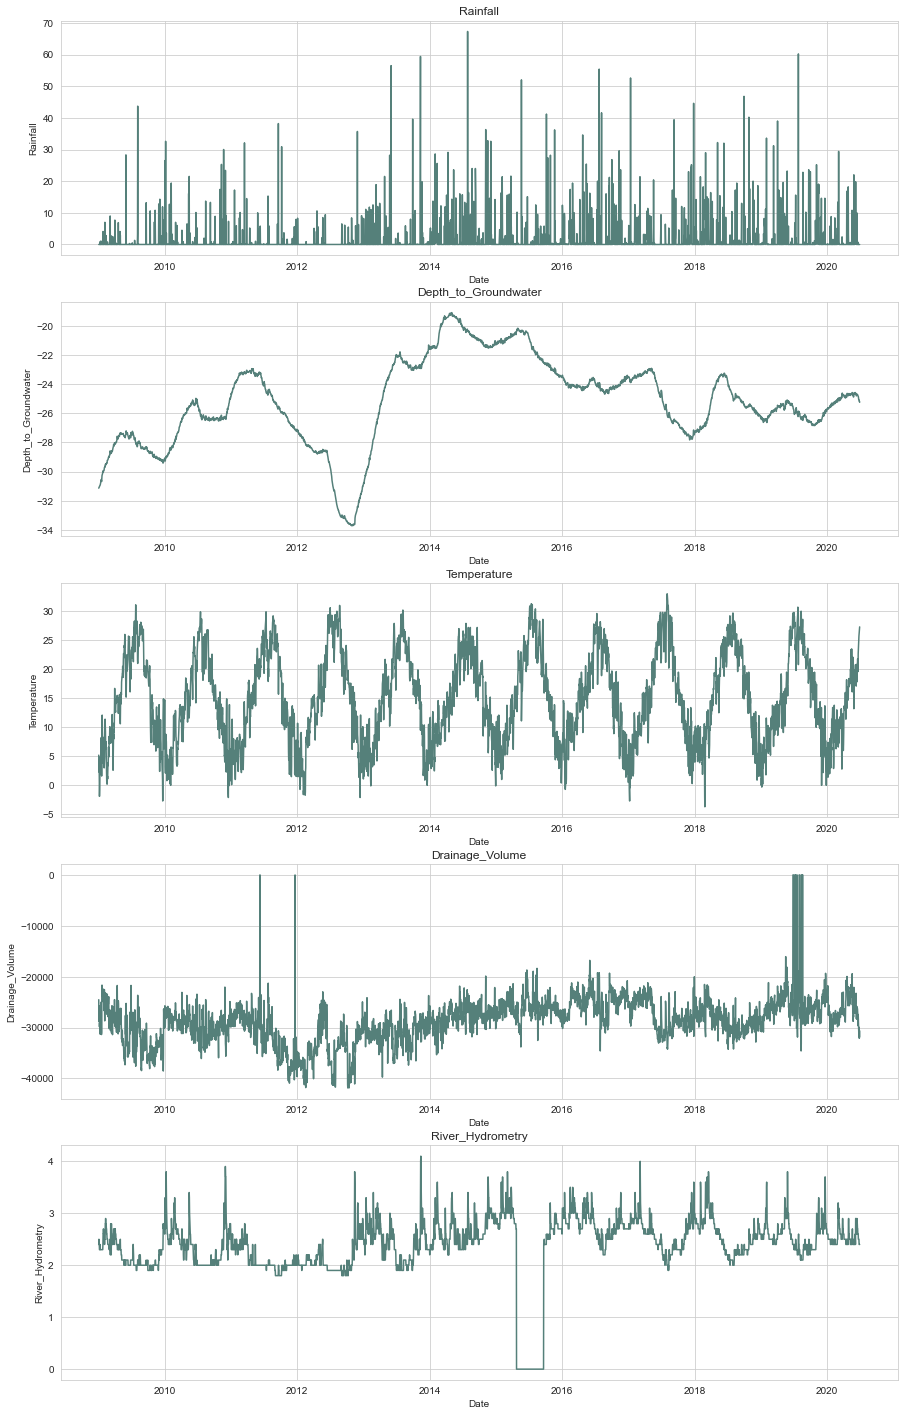

In [55]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))
def sketch_plot(variable, axes):
    g = sns.lineplot(
        data = df, 
        x = 'Date', 
        y = variable,
        ax = axes,
        color = '#55807a'
    )
    axes.set_title(variable, fontsize = 12)

sketch_plot('Rainfall', ax[0])
sketch_plot('Depth_to_Groundwater', ax[1])
sketch_plot('Temperature', ax[2])
sketch_plot('Drainage_Volume', ax[3])
sketch_plot('River_Hydrometry', ax[4])

### Handling Inconsistencies

In [73]:
df.isna().value_counts() #Total rows with already missing values

Date   Rainfall  Depth_to_Groundwater  Temperature  Drainage_Volume  River_Hydrometry
False  False     False                 False        False            False               3996
                                                                     True                 150
                 True                  False        False            False                 27
                 False                 False        True             False                 26
dtype: int64

#### Missing Values - In the previous plots, [River Hydromentery] and [Drainage_Volume] can be seen having 0 values, we will have these missing values replaced with null values

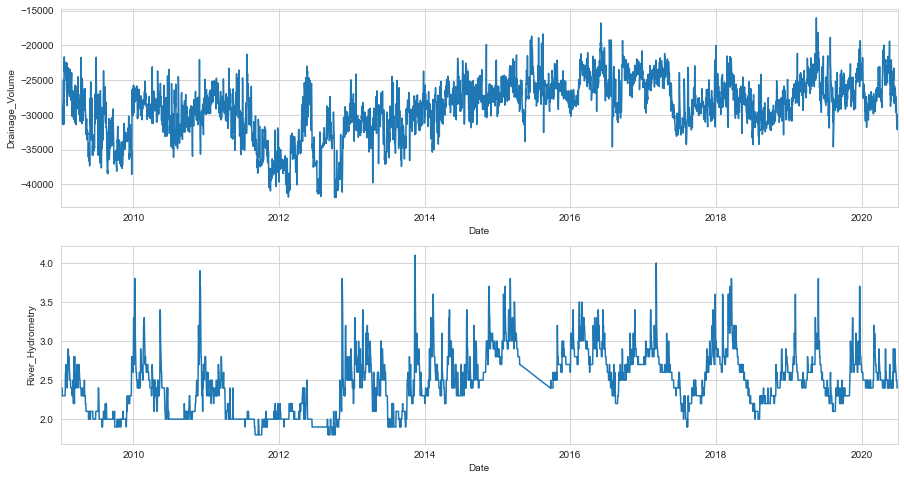

In [57]:
df.Drainage_Volume = np.where(df.Drainage_Volume == 0, np.nan, df.Drainage_Volume)
df.River_Hydrometry = df.River_Hydrometry.mask(df.River_Hydrometry == 0, np.nan)

f, ax = plt.subplots(2,1, figsize=(15, 8))
sns.lineplot(x = df.Date, y = df.Drainage_Volume, ax= ax[0])
sns.lineplot(x = df.Date, y = df.River_Hydrometry, ax= ax[1])
for i in range(2):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

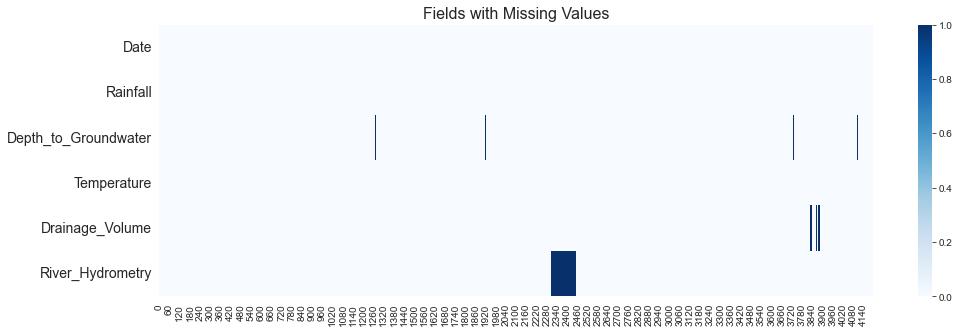

In [60]:
f, ax = plt.subplots(1, 1, figsize=(16,5))
sns.heatmap(df.T.isna(), cmap='Blues')
plt.yticks(fontsize = 12)
plt.show()

#### An effective solution for subtituting null data have to be decided, below plots compares the four options:
- Filling null values with 0
- Filling null values with mean value
- Filling null values with ffill
- Filling null values with interpolation

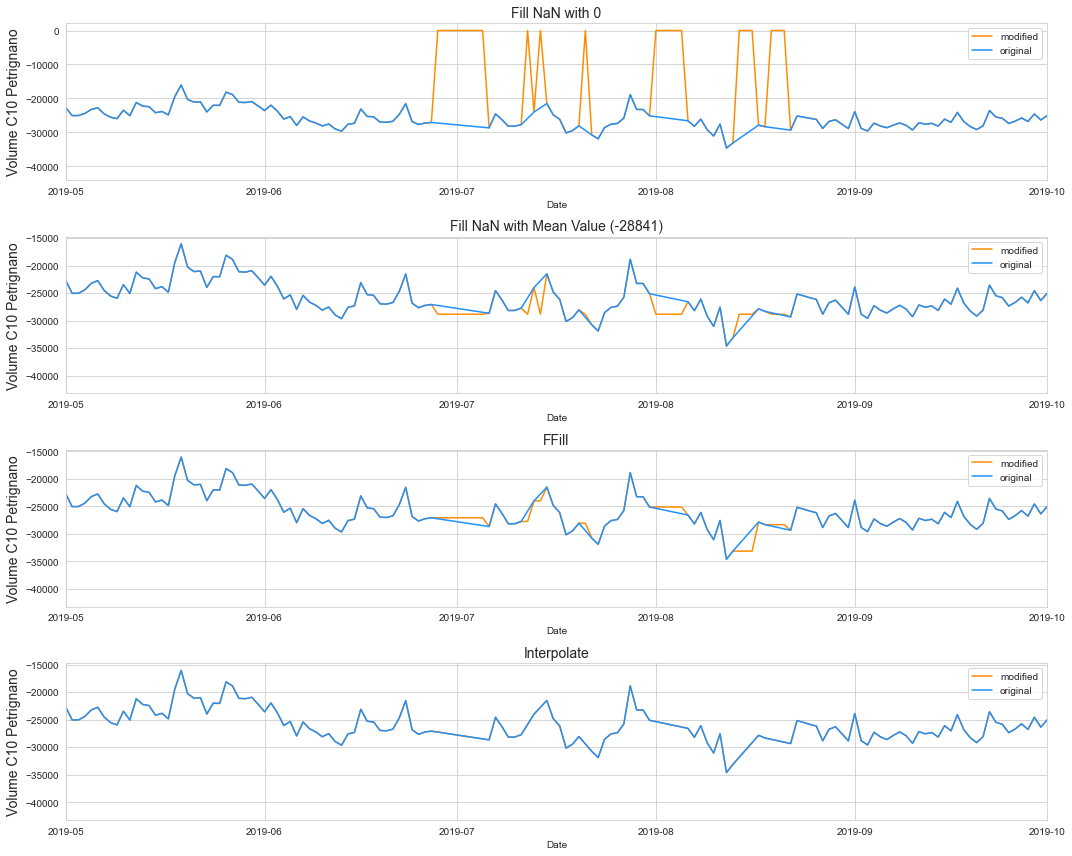

In [74]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_val = df.Drainage_Volume.mean()
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(mean_val), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_val:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
plt.tight_layout()
plt.show()

#### Since interpolation provides a close representation to the original way the data is ordered, it will be the chosen method going forward:

In [78]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()